# Bone marrow myeloid Cells acute (4h) response to LPS-SI
Author: Farid Keramati  
Date: 21/09/2022

Use the following code to characterize the acute (4h) response of bone marrow-resident hematopoietic stem cells (HSCs) and myeloid cells to LPS-induced systemic inflammation.  
To run the following code, we will use the Seurat object generated in the [**first analysis script**](https://github.com/fkeramati/LPS-SI/blob/main/Analysis%20Scripts/All%20Bone%20Marrow%20Mononuclear%20Cell%20from%20All%20Time%20Points.ipynb).<br></br>
First, we will subset day 0 and 4 hours samples and then will subset HSCs and myeloid cells.

### Load required packages

In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratWrappers))

### Read in previously generated Seurat object and subset HSC + myeloid cells

In [2]:
bm = readRDS("./Bonemarrow_allCells_allTimePoints_MNN_batchCorrected.rds")
bm = subset(bm, subset = TimePoint == "D7", invert = T)
myelo_tmp = subset(bm, idents = c("HSC", "GMP", "Monocyte", "Inflam Mono", "Non Cla Mono", "cDC"))

counts = GetAssayData(myelo_tmp, slot = "counts")
myelo = CreateSeuratObject(counts = counts, project = "myelo", min.cells = 0, min.features = 0)
rm(myelo_tmp, counts)

### Normalize, scale and perform dimentionality reduction
After each round of visualization, I will remove few contaminating cells (from other lineages), to get to a pure population of HSC + Myeloid cells.

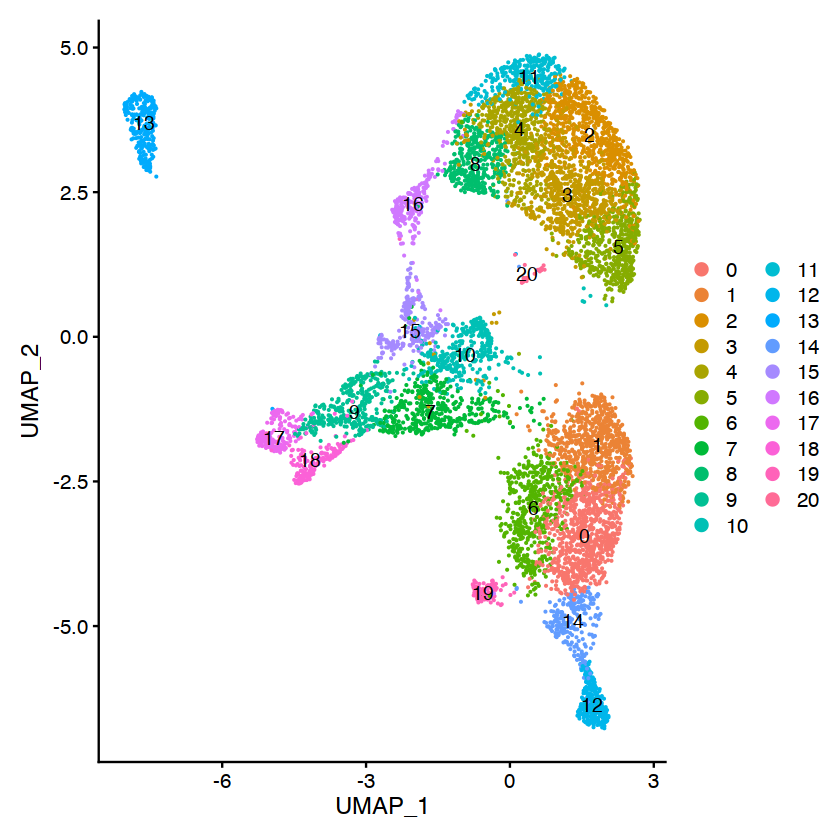

In [3]:
# Normalize and Scale
myelo = NormalizeData(myelo, normalization.method = "LogNormalize", scale.factor = 10000, verbose = F)
myelo = FindVariableFeatures(myelo, selection.method = "vst", nfeatures = 3000, verbose = F)
s.genes = cc.genes.updated.2019$s.genes
g2m.genes = cc.genes.updated.2019$g2m.genes
myelo = CellCycleScoring(myelo, s.features = s.genes, g2m.features = g2m.genes, set.ident = T)
myelo$CC.Difference = myelo$S.Score - myelo$G2M.Score
myelo = ScaleData(myelo, features = rownames(myelo), verbose = F)

# PCA, UMAP visualization and clustering
myelo = RunPCA(myelo, ndims.print = 1:30, verbose = F)
myelo = RunUMAP(myelo, min.dist = 0.2, spread = 0.5, dims = 1:16, verbose = F)
myelo = FindNeighbors(myelo, dims = 1:16, k.param = 20, verbose = F)
myelo = FindClusters(myelo, resolution = 1.3, verbose = F)
myelo@meta.data$Donor = unlist(strsplit(names(myelo$orig.ident), split = "_"))[c(T,F,F)]
myelo@meta.data$TimePoint = unlist(strsplit(names(myelo$orig.ident), split = "_"))[c(F,T,F)]
DimPlot(myelo, label = T, pt.size = 0.1)

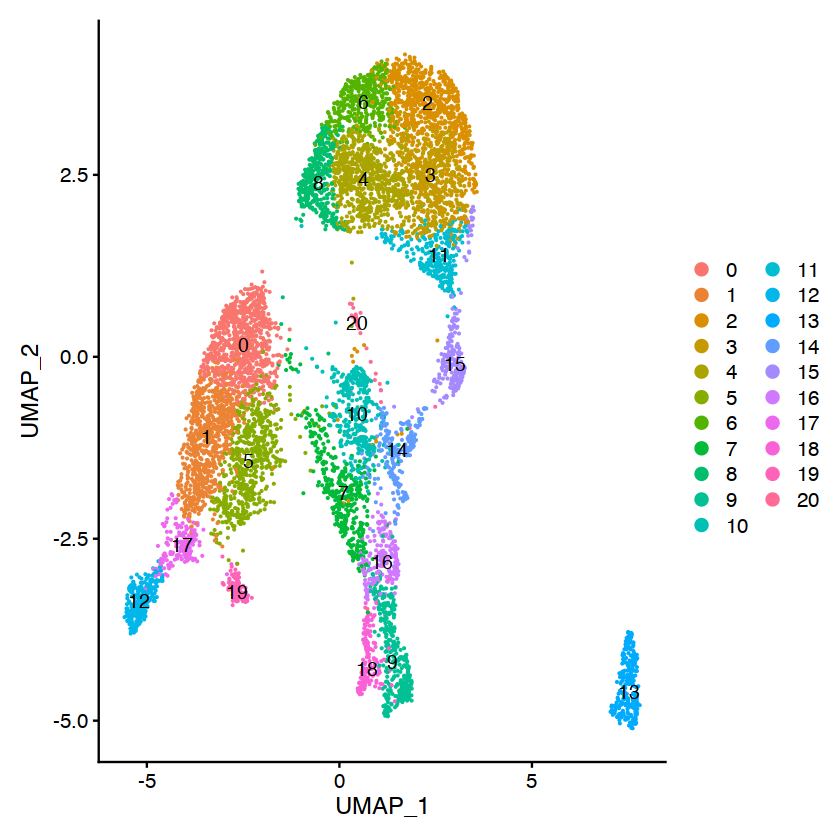

In [4]:
# Remove cluster 20 (contaminating stromal cells in the myeloid lineage)
myelo = subset(myelo, idents = 20, invert = T)

# Run normalization and clustering again
myelo = FindVariableFeatures(myelo, selection.method = "vst", nfeatures = 3000, verbose = F)
myelo = ScaleData(myelo, features = rownames(myelo), verbose = F)
myelo = RunPCA(myelo, ndims.print = 1:30, verbose = F)
myelo = RunUMAP(myelo, min.dist = 0.2, spread = 0.5, dims = 1:17, verbose = F)
myelo = FindNeighbors(myelo, dims = 1:17, k.param = 20, verbose = F)
myelo = FindClusters(myelo, resolution = 1.3, verbose = F)
DimPlot(myelo, label = T, pt.size = 0.1)

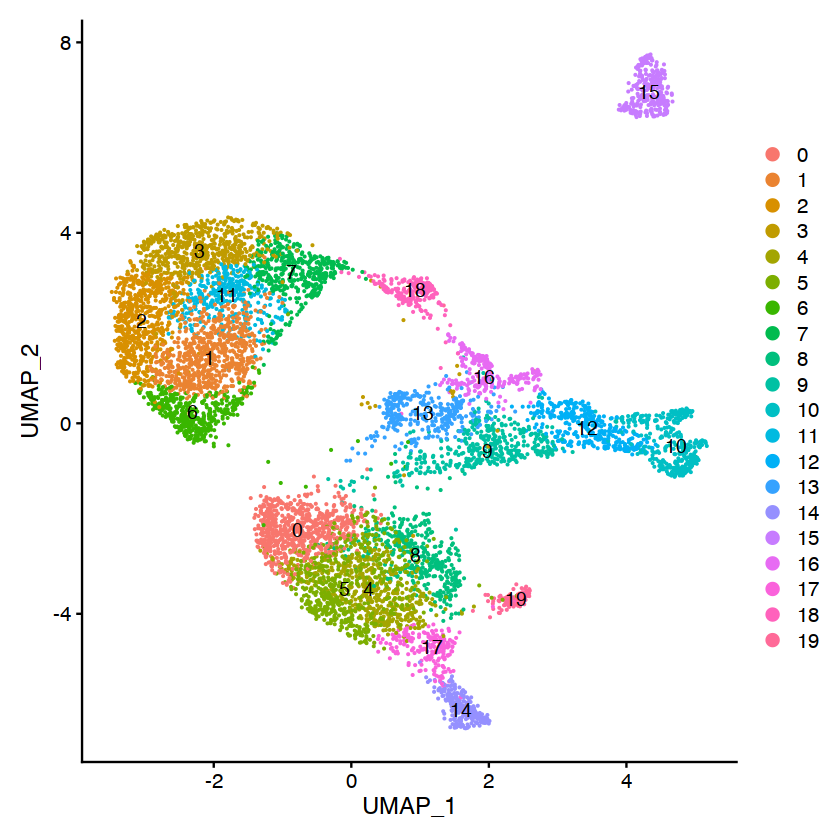

In [5]:
# Remove cluster 20 (contaminating Erythrocytes in the myeloid lineage)
myelo = subset(myelo, idents = 20, invert = T)

# Run normalization and clustering again
myelo = FindVariableFeatures(myelo, selection.method = "vst", nfeatures = 3000, verbose = F)
myelo = ScaleData(myelo, features = rownames(myelo), verbose = F)
myelo = RunPCA(myelo, ndims.print = 1:30, verbose = F)
myelo = RunUMAP(myelo, min.dist = 0.2, spread = 0.5, dims = 1:17, verbose = F)
myelo = FindNeighbors(myelo, dims = 1:17, k.param = 20, verbose = F)
myelo = FindClusters(myelo, resolution = 1.3, verbose = F)
DimPlot(myelo, label = TRUE, pt.size = 0.1)

### Batch correct using MNN and visualize cells

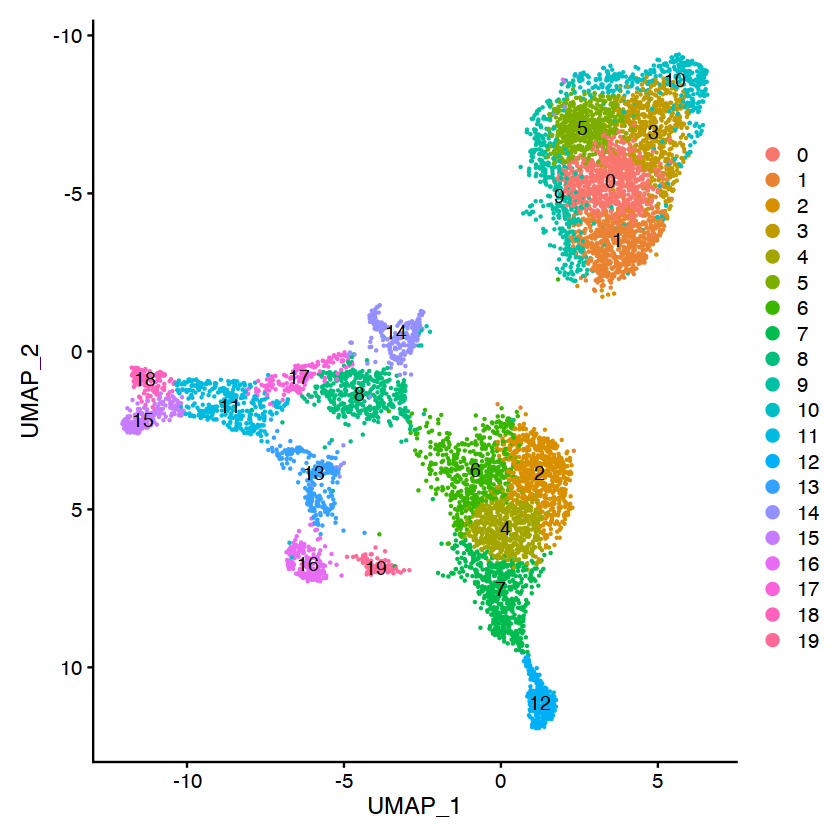

In [6]:
# There is a donor batch effect, correct for it using MNN
myelo_mnn = RunFastMNN(object.list = SplitObject(myelo, split.by = "Donor"), features = 2000, verbose = F)
myelo_mnn = RunUMAP(myelo_mnn, dims = 1:20, reduction = "mnn", verbose = F)
myelo_mnn = FindNeighbors(myelo_mnn, dims = 1:20, reduction = "mnn", verbose = F)
myelo_mnn = FindClusters(myelo_mnn, resolution = 2, verbose = F)
DimPlot(myelo_mnn, label = T) + scale_y_reverse()

### Refine cell clustering and assign cells types to each cluster
Cell type assignment is based on known canonical markers.

In [7]:
# Further sub-cluster cluster 2
myelo_mnn = FindSubCluster(myelo_mnn, cluster = 2, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.3, algorithm = 1)
Idents(myelo_mnn) = myelo_mnn$sub.cluster

# Further sub-cluster cluster 6
myelo_mnn = FindSubCluster(myelo_mnn, cluster = 6, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.6, algorithm = 1)
Idents(myelo_mnn) = myelo_mnn$sub.cluster

# Further sub-cluster cluster 7
myelo_mnn = FindSubCluster(myelo_mnn, cluster = 7, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.3, algorithm = 1)
Idents(myelo_mnn) = myelo_mnn$sub.cluster

# Further sub-cluster cluster 8
myelo_mnn = FindSubCluster(myelo_mnn, cluster = 8, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.3, algorithm = 1)
Idents(myelo_mnn) = myelo_mnn$sub.cluster

# Further sub-cluster cluster 11
myelo_mnn = FindSubCluster(myelo_mnn, cluster = 11, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.2, algorithm = 1)
Idents(myelo_mnn) = myelo_mnn$sub.cluster

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 678
Number of edges: 20191

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7058
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 539
Number of edges: 15886

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6234
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 536
Number of edges: 19795

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7583
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 408
Number of edges: 11012

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7682
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version

In [8]:
# Name the clusters
myelo_mnn = RenameIdents(myelo_mnn, "0" = "Inflam Pro Mono",  
                         "1" = "Inflam Pro Mono", 
                         "2_0" = "Pro Mono",
                         "2_1" = "Monocyte",
                         "3" = "Inflam Mono", 
                         "4" = "Monocyte",
                         "5" = "Inflam Pro Mono", 
                         "6_0" = "Pro Mono",
                         "6_1" = "Pro Mono",
                         "6_2" = "Monocyte",
                         "6_3" = "Pro Mono",
                         "7_0" = "Monocyte",
                         "7_1" = "Inter Mono",
                         "8_0" = "GMP",
                         "8_1" = "Cycling Pro Mono",
                         "9" = "Inflam Pro Mono", 
                         "10" = "Inflam Mono", 
                         "11_0" = "ST-HSC", 
                         "11_1" = "Inflam ST-HSC", 
                         "12" = "Non Cla Mono", 
                         "13" = "Prog cDC", 
                         "14" = "Cycling Inflam Pro Mono", 
                         "15" = "LT-HSC", 
                         "16" = "Inflam cDC", 
                         "17" = "Inflam GMP", 
                         "18" = "Inflam LT-HSC",
                         "19" = "cDC")
myelo_mnn$CellType = myelo_mnn@active.ident
myelo_mnn$CellType = factor(myelo_mnn$CellType, levels = c("LT-HSC", "ST-HSC", "Inflam LT-HSC", "Inflam ST-HSC", "GMP", "Inflam GMP", 
                                                           "Cycling Pro Mono", "Cycling Inflam Pro Mono", "Prog cDC", "Pro Mono", "Monocyte", "Inter Mono", 
                                                           "Non Cla Mono", "Inflam Pro Mono", "Inflam Mono", "cDC", "Inflam cDC"))

### Visualize cells (colored by cell type)

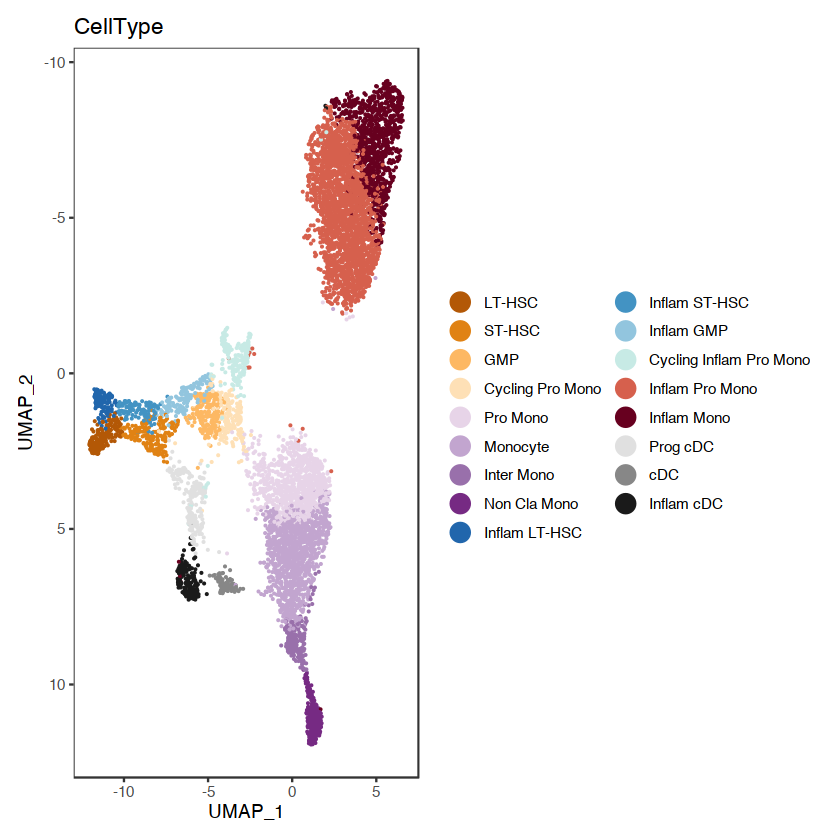

In [9]:
DimPlot(myelo_mnn, pt.size=0.1, group.by="CellType") + theme_bw() + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) +
  scale_color_manual(values=c("LT-HSC"="#b35806",
                              "ST-HSC"="#e08214",
                              "GMP"="#fdb863",
                              "Cycling Pro Mono"="#fee0b6",
                              "Pro Mono"="#e7d4e8",
                              "Monocyte"="#c2a5cf",
                              "Inter Mono"="#9970ab",
                              "Non Cla Mono"="#762a83",
                              "Inflam LT-HSC"="#2166ac", 
                              "Inflam ST-HSC"="#4393c3",
                              "Inflam GMP"="#92c5de", 
                              "Cycling Inflam Pro Mono"="#c7eae5", 
                              "Inflam Pro Mono"="#d6604d", 
                              "Inflam Mono" = "#67001f", 
                              "Prog cDC"="#e0e0e0", 
                              "cDC"="#878787",
                              "Inflam cDC"="#1a1a1a")) +
  guides(color=guide_legend(ncol=2, override.aes = list(size=5))) + scale_y_reverse()

### Visualize cells (colored by time point)

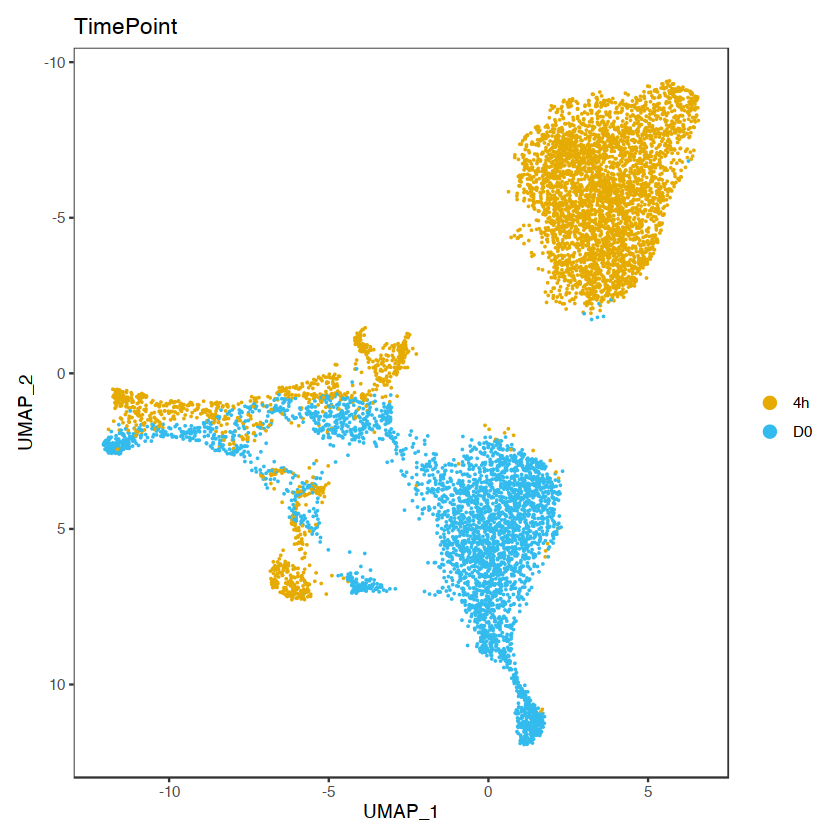

In [10]:
DimPlot(myelo_mnn, label = F, pt.size = 0.01, group.by = "TimePoint", shuffle = T) + scale_color_manual(values=c("#e6ab02", "#33bbee", "#ee3377")) +
  theme_bw() + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) + scale_y_reverse()

### Save object
You can save **myelo** object to use it in the future.

In [11]:
saveRDS(myelo_mnn, "Myeloid_HSC_Day0_4h_MNN_batchCorrected.rds")